In [1]:
# load the packages and functions

# auto-reload edited moduleås
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
# set the correct directories based on official ASTE
forward_path = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirdiags = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/BUDG/"
dirstate = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/diags/STATE/"

# layers path here is for what time steps?
layers_path2007 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"
layers_path2016 = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2016_capxxN50_it0062_pk0000736272_bro/"
layers_path = "/scratch3/atnguyen/aste_270x450x180/run_c68v_layers_lessmem1_adxOFF_Jan2007_capxxN50_it0062_pk0000262944_bro/"


In [3]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

# load the indices from file
data = np.load("/home/mmurakami/crios_backups/an_helper_functions/gates_BSO.npz")

y_bsoh, x_bsoh = data["y_bsoh"], data["x_bsoh"]
y_bsov, x_bsov = data["y_bsov"], data["x_bsov"]

y_fjnzv, x_fjnzv = data["y_fjnzv"], data["x_fjnzv"]
y_fjnz,  x_fjnz  = data["y_fjnz"],  data["x_fjnz"]

y_nzruv, x_nzruv = data["y_nzruv"], data["x_nzruv"]

y_spfjh, x_spfjh = data["y_spfjh"], data["x_spfjh"]
y_spfjv, x_spfjv = data["y_spfjv"], data["x_spfjv"]
y_spfjb, x_spfjb = data["y_spfjb"], data["x_spfjb"]

print("keys:", list(data.keys()))

keys: ['y_bsoh', 'x_bsoh', 'y_bsov', 'x_bsov', 'y_fjnzv', 'x_fjnzv', 'y_fjnz', 'x_fjnz', 'y_nzruv', 'x_nzruv', 'y_spfjh', 'x_spfjh', 'y_spfjv', 'x_spfjv', 'y_spfjb', 'x_spfjb']


In [188]:
# let's move the gate calculation to a function to show a timeseries
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(2,4,1)
print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

{'2007': array([2, 3])}


2419200.0

In [189]:
# create the ADVhT and ADVhS manually here
t2 = int(tsstr[1])

In [190]:
# LOAD ADV FOR BOTH T AND S
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

# for temp, get convergence
ADV_hconvT = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconvT = ADV_hconvT   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconvT

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv   # PSU·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhS = ADV_hconv

In [191]:
# # get the gateway transports for the same region
# from create_layers import create_gates

# G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT, G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = create_gates(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy,y_bsoh,x_bsoh,y_bsov,x_bsov,y_fjnzv,x_fjnzv,y_nzruv,x_nzruv,y_spfjh,x_spfjh,y_spfjv,x_spfjv,y_spfjb,x_spfjb)

In [192]:
# MsumS = G_BSOS + G_FJNZS + G_SPFJS+ G_NZRUS   # overall transport in S
# MsumT = G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT  # overall transport in T
# MsumS[np.isnan(MsumS)] = 0
# MsumT[np.isnan(MsumT)] = 0

In [193]:
# print(np.nansum(MsumS))

In [194]:
# print(np.nansum(ADVhS * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))))

In [195]:
# just copy over exactly what we have in wmt_spellout
# we need to also create the theta and salt bins for this area
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(forward_path + "diags/STATE/" + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(forward_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(forward_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [196]:
def get_gates3d(ADVx,ADVy,TRACER,nz,ny,nx):

    # define a function to take some ADV term and x and y, and the tracer field THETA and produce only those filled
    # define + as into the basin
    
    # --- reshape to 3D ---
    ADVx = ADVx.reshape((nz, ny, nx))   # advective heat flux on x-faces
    ADVy = ADVy.reshape((nz, ny, nx))   # advective heat flux on y-faces
    TRACER   = TRACER.reshape((nz, ny, nx))     # cell-centered temperature
    
    # ---- BSO ----
    ADV_west = np.zeros((nz, ny, nx))
    # horizontal faces (u-faces)
    for j, i in zip(y_bsoh, x_bsoh):
        # flux through x-face at (j,i) mapped into cell (j,i)
        ADV_west[:, j, i] += ADVx[:, j, i]    # + into basin
    
    # vertical faces (v-faces)
    for j, i in zip(y_bsov, x_bsov):
        # flux through y-face at (j,i) mapped into cell (j-1,i)
        ADV_west[:, j-1, i] -= ADVy[:, j, i]  # sign chosen so + into basin
    
    # ---- FJNZ ----
    ADV_FJNZ = np.zeros((nz, ny, nx))
    ADV_FJNZ[:,y_fjnz,x_fjnzv[0]-1] = -ADVx[:, y_fjnz, x_fjnzv[0]]
    
    # ---- SPFJ (NZ exit) ----
    ADV_SPFJ = np.zeros((nz, ny, nx))
    ADV_SPFJ[:,y_spfjv,x_spfjv-1] -= ADVx[:, y_spfjv, x_spfjv]
    ADV_SPFJ[:,y_spfjh-1,x_spfjh] -= ADVy[:, y_spfjh, x_spfjh]
    ADV_SPFJ[:,y_spfjb-1,x_spfjb] -= ADVy[:, y_spfjb, x_spfjb]
    ADV_SPFJ[:,y_spfjb,x_spfjb-1] -= ADVx[:, y_spfjb, x_spfjb]  # this fixed the issue
    
    # ---- NZRU (small Russia gate) ----
    ADV_NZRU = np.zeros((nz, ny, nx))
    y_nzru_all = np.array([], dtype=int)
    x_nzru_all = np.array([], dtype=int)
    
    for j, i in zip(y_nzruv, x_nzruv):
        ADV_NZRU[:, j, i-1] -= ADVx[:, j, i]   # + into basin
        y_nzru_all = np.append(y_nzru_all, j)
        x_nzru_all = np.append(x_nzru_all, i-1)

    # later we will need to define a small gate for the midway point through the basin and confirm similarity

    return ADV_west, ADV_FJNZ, ADV_SPFJ, ADV_NZRU

ADV_westT, ADV_FJNZT, ADV_SPFJT, ADV_NZRUT = get_gates3d(ADVx_TH,ADVy_TH,THETA,nz,ny,nx)
ADV_westS, ADV_FJNZS, ADV_SPFJS, ADV_NZRUS = get_gates3d(ADVx_SLT,ADVy_SLT,SALT,nz,ny,nx)

In [197]:
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
print(np.nansum(ADVhT * mymsk3d))
print()

print(np.nansum(ADV_westT))
print(np.nansum(ADV_FJNZT))
print(np.nansum(ADV_SPFJT))
print(np.nansum(ADV_NZRUT))

print()

print(np.nansum(ADV_westT) + np.nansum(ADV_FJNZT) + np.nansum(ADV_SPFJT) + np.nansum(ADV_NZRUT)) ## yay! this is budgeted :)

11654809.637513466

12564191.065285953
-528888.1882470024
-234046.01945087232
-146447.2200746051

11654809.637513472


In [198]:
mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
print(np.nansum(ADVhS * mymsk3d))
print()

print(np.nansum(ADV_westS))
print(np.nansum(ADV_FJNZS))
print(np.nansum(ADV_SPFJS))
print(np.nansum(ADV_NZRUS))

print()

print(np.nansum(ADV_westS) + np.nansum(ADV_FJNZS) + np.nansum(ADV_SPFJS) + np.nansum(ADV_NZRUS)) ## yay! this is budgeted :)

-1142098.5064895896

61036213.24007856
-54629111.07587317
-10255394.454924498
2706193.7842295286

-1142098.5064895744


In [199]:

def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

# define a function to turn the gates as 3D into 1D for T and S
def gateway3D(ADV_west,ADV_FJNZ,ADV_SPFJ,ADV_NZRU,tracer,binmidTracer,nTm1):
    tracer_flat = tracer.ravel()
    bin_idx_mid = np.digitize(tracer_flat, binmidTracer, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(tracer_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # flatten these so we can bin
    ADV_west_flat   = ADV_west.ravel()
    ADV_fjnz_flat   = ADV_FJNZ.ravel()
    ADV_spfj_flat   = ADV_SPFJ.ravel()
    ADV_nzru_flat   = ADV_NZRU.ravel()

    # per-bin sums with NaN-propagation
    ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
    ADVh_FJNZ = _bincount_sum_with_nan(idx_mid, ADV_fjnz_flat[valid_mid], nTm1)
    ADVh_SPFJ = _bincount_sum_with_nan(idx_mid, ADV_spfj_flat[valid_mid], nTm1)
    ADVh_NZRU = _bincount_sum_with_nan(idx_mid, ADV_nzru_flat[valid_mid], nTm1)
    
    # edge-based G (m^3/s): divide by edge binwidths
    G_BSO = ADVh_BSO #/ binwidthT1
    G_FJNZ = ADVh_FJNZ #/ binwidthT1
    G_SPFJ = ADVh_SPFJ #/ binwidthT1
    G_NZRU = ADVh_NZRU #/ binwidthT1

    return G_BSO,G_FJNZ,G_SPFJ,G_NZRU

In [200]:
# also load the bins again so we have them locally
## load the TS bins
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1

binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]

binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])

binmidT = (boundsT[1:] + boundsT[:-1]) /2
binmidS = (boundsS[1:] + boundsS[:-1]) /2

nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

In [201]:
G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT = gateway3D(ADV_westT,ADV_FJNZT,ADV_SPFJT,ADV_NZRUT,THETA,binmidT,nTm1)  # in tracer.m^3/s
G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = gateway3D(ADV_westS,ADV_FJNZS,ADV_SPFJS,ADV_NZRUS,SALT,binmidS,nSm1)  # in tracer.m^3/s

In [202]:
MsumT = G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT  # overall transport in T
MsumT[np.isnan(MsumT)] = 0

In [203]:
print(np.nansum(MsumT) - (np.nansum(ADVhT * mymsk3d)))  # budgeted!

3.725290298461914e-09


In [204]:
# do again for SALT
MsumS = G_BSOS + G_FJNZS + G_SPFJS + G_NZRUS  # overall transport in S
MsumS[np.isnan(MsumS)] = 0

In [205]:
print(np.nansum(MsumS) - (np.nansum(ADVhS * mymsk3d)))  # budgeted!

-2.3283064365386963e-10


In [206]:
# now we can move on. what is the next step?
# develop a climatology based on the months available
# which term/gate is most responsible for the changes over time?

## Moving on, we now have the ability to budget these as a bar chart (I think) using either layers or not layers.

In [207]:
print(np.nansum((G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT)) / np.nansum(binwidthT1))  # in m^3/s

278490.07497045334


In [208]:
# redefine all the terms as a list from how we did before

# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((1, nT-1))
dF_Tnew = np.zeros((1, nT-1))
Lijnew = np.zeros((1, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

# define the ADVh total for this mymsk2
G_S_offline_new = np.zeros((1, nS-1))
dF_Snew = np.zeros((1, nS-1))
Lijnew = np.zeros((1, nS-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
S_flat    = np.ravel(SALT* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhS* mymsk3d,  order='F')

for i in range(nS-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((S_flat >= binmidS[i]) & (S_flat < binmidS[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Snew[0, i] = np.nansum(ADVh_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_S_offline_new = dF_Snew / binwidthS1[None, :]


In [209]:
print(np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1))

278490.07497045334


(32.0, 36.0)

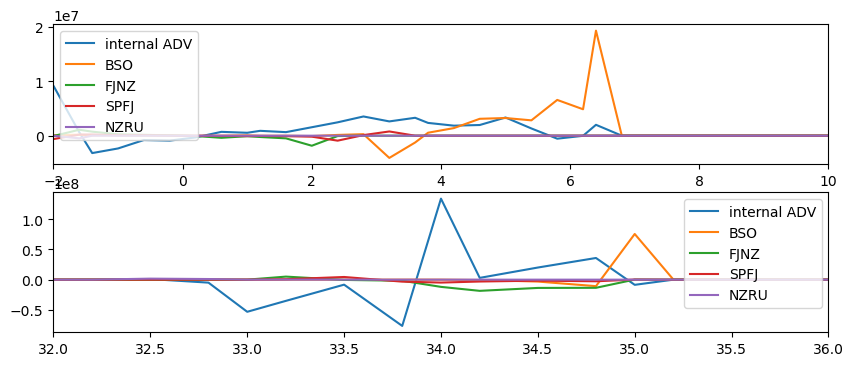

In [210]:
# let's just plot the advective term (copy from layers output) and the gates here
fig = plt.figure()

ax = plt.subplot(211)

ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label="internal ADV")
# also plot all of the gates
ax.plot(boundsT.flatten()[1:-1],G_BSOT/binwidthT1,label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZT/binwidthT1,label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJT/binwidthT1,label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRUT/binwidthT1,label="NZRU")
ax.legend(loc="best")
ax.set_xlim(-2,10)


ax = plt.subplot(212)

ax.plot(boundsS.flatten()[1:-1],G_S_offline_new[0],label="internal ADV")
ax.plot(boundsS.flatten()[1:-1],G_BSOS,label="BSO")
ax.plot(boundsS.flatten()[1:-1],G_FJNZS,label="FJNZ")
ax.plot(boundsS.flatten()[1:-1],G_SPFJS,label="SPFJ")
ax.plot(boundsS.flatten()[1:-1],G_NZRUS,label="NZRU")
ax.legend(loc="best")
ax.set_xlim(32,36)


In [211]:
print(np.nansum((G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT)) / np.nansum(binwidthT1))  # in m^3/s
print(np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1))
print()
print(np.nansum((G_BSOS + G_FJNZS + G_SPFJS + G_NZRUS)) / np.nansum(binwidthS1))  # in m^3/s
print(np.nansum(dF_Snew[0]) / np.nansum(binwidthS1))
print()

278490.07497045334
278490.07497045334

-28987.271738314463
-28987.271738314394



In [212]:
# am I reading layers correctly? I think so, but outout will not be the same.
# but regardless we can make the climatology over the period/show that these are similar

In [213]:
# I think it would be easier to port everything to a function, then plot
# this requires that I am doing tend correctly but I hope to god so.

In [214]:
# we need to generate the output across all timesteps in the ASTE period
# we need to show which term is the largest and see how the layers highlighted years compare to this
# maybe this can give some valuable insights

# try to do this for just one year in the period

In [229]:
# let's move the gate calculation to a function to show a timeseries
# define tstep 
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(1,13,1)
times['2008'] = np.array([1])

times = {}
# times['2007'] = np.arange(1,3,1)
times['2008'] = np.arange(3,6,1)

print(times)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstr
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

{'2008': array([3, 4, 5])}


2678400.0

## manually define the create_layersTHETA

In [230]:
# create the total tendency first
# from create_layers import create_layersTHETA,create_layersSALT


def create_layersTHETA(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy,dt):
    # we want to create dF_Tnew, basically, which contains the information from the layers output mimicked by ASTER1
    # let's just check with ADVh first
    mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
    t2 = int(tsstr[1])
    hf = mygrid['hFacC']
    RAC = mygrid['RAC']
    
    # load THETA
    file_name = "state_3d_set1"
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
    THETA = THETA.reshape(nz,ny,nx)
    SALT = SALT.reshape(nz,ny,nx)

    # LOAD ADV FOR BOTH T AND S
    file_name = "budg3d_hflux_set2"
    meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    
    # for temp, get convergence
    ADV_hconvT = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
    ADV_hconvT = ADV_hconvT   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
    ADVhT = ADV_hconvT
    
    # now 3d zfluxes
    file_name = "budg3d_zflux_set2"
    meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
    varnames = np.array(["ADVr_TH","ADVr_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

    # for temp, get convergence
    trWtopADV = -(ADVr_TH)
    ADVrT = np.zeros((nz,ny,nx),dtype=float)
    ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])
    
    ## load the TS bins
    boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
    nT = boundsT.size - 1
    boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
    nS = boundsS.size - 1
    
    binwidthT = boundsT[1:] - boundsT[:-1]
    binwidthS = boundsS[1:] - boundsS[:-1]
    
    binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
    binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])
    
    binmidT = (boundsT[1:] + boundsT[:-1]) /2
    binmidS = (boundsS[1:] + boundsS[:-1]) /2
    
    nT = nT
    nS = nS
    nTm1 = nT-1
    nSm1 = nS-1

    # create the diffusive term
    ## do the advective convergence
    file_name = "budg3d_hflux_set2"
    meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["DFxE_TH","DFyE_TH"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    DFxE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    DFyE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    # now 3d zfluxes
    file_name = "budg3d_zflux_set2"
    meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
    varnames = np.array(["DFrE_TH","DFrI_TH"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    DFrE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    DFrI_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
    DFrI_TH = DFrI_TH.reshape(nz,ny,nx)
    
    DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_TH.reshape(nz, ny, nx), nfx, nfy))
    DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
    DFhT = DF_hconv
    
    trWtopDF = -(DFrE_TH+DFrI_TH)
    
    DFrT = np.zeros((nz,ny,nx),dtype=float)
    DFrT[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])
    
    # to get the surface term, we need J/s and convert to degC.m^3/s
    file_name = 'budg2d_zflux_set1'
    meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
    varnames = np.array(["TFLUX","oceQsw","SItflux"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    TFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    oceQsw,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    SItflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
    TFLUX = TFLUX.reshape(ny,nx)
    oceQsw = oceQsw.reshape(ny,nx)
    SItflux = SItflux.reshape(ny,nx)
    
    # we need to create zconv_top and swtop
    dd = mygrid['RF'][:-1]
    swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
    swfrac[dd < -200] = 0
    swtop=mk3D_mod(swfrac,np.zeros((nz,ny,nx)))*mk3D_mod(RAC*oceQsw,np.zeros((nz,ny,nx)))   # J/s
    
    # zconvtop_heat is here
    zconv_top_heat = TFLUX * RAC     # W/m^2 * m^2 = J/s
    
    
    def surface_contrib_JT(zconv_top_heat, swtop, rcp, fill_last=0.0):
        """
        zconv_top_heat: (ny, nx)
        swtop:          (nz, ny, nx)
        rcp:            scalar
        fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
        returns:
          JsurfT:       (nz, ny, nx)  # Sv / PSU
        """
        nz, ny, nx = swtop.shape
    
        eT = zconv_top_heat.reshape(1, ny, nx)  # (1,ny,nx) for broadcast
    
        J = np.empty_like(swtop, dtype=float)
    
        # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
        J[0] = (eT[0] - swtop[1]) / rcp if np.ndim(binwidthT)==0 else \
               (eT[0] - swtop[1]) / rcp
    
        # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
        J[1:nz-1] = -(swtop[2:nz] - swtop[1:nz-1]) / rcp
    
        # bottom slice (k = nz-1): no k+1; choose your boundary convention
        J[-1] = fill_last
        return J
    
    Ft_surftest = surface_contrib_JT(zconv_top_heat,swtop,myparms['rcp'])    # this is in degC.m^3/s
    
    # read kpp tend and from 3d zflux
    file_name = "budg3d_kpptend_set1"
    meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
    varnames = np.array(["KPPg_TH"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    KPPg_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    KPPg_TH = KPPg_TH.reshape(nz,ny,nx)
    
    # do the vertical convergence for KPP
    trWtopKPP = -(KPPg_TH)         # degC.m^3/s
    
    tmpkpp = np.full((nz,ny,nx),np.nan)
    tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
    
    
    # load the tend from the get_Jterms and plot this
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    for i in range(len(tsstr)):
        thisTHETADR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
        thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
        THETADR[i] = thisTHETADR
    
    THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/
    AB_gT = 0
    tmptend=(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # degC.m/s * m^2 = degC.m^3/s
    tmptend = tmptend                          # degC.m^3/s

    # redefine all the terms as a list from how we did before

    # define the ADVh total for this mymsk2
    G_T_offline_new = np.zeros((7, nT-1))
    dF_Tnew = np.zeros((7, nT-1))
    Lijnew = np.zeros((7, nT-1), dtype=int)
    
    # also mask these by mymsk3
    # flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
    T_flat    = np.ravel(THETA* mymsk3d, order='F')
    ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
    ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
    DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
    DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
    surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
    kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
    tend_flat = np.ravel(tmptend* mymsk3d,  order='F')
    
    for i in range(nT-1):
        # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
        ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
        Lijnew[0, i] = len(ij)
    
        if len(ij) > 0:
            # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
            dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
            dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
            dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
            dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
            dF_Tnew[4, i] = np.nansum(surf_flat[ij])
            dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
            dF_Tnew[6, i] = np.nansum(tend_flat[ij])
    
    # MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
    G_T_offline_new = dF_Tnew / binwidthT1[None, :]
    
    return G_T_offline_new,dF_Tnew  # these will be in units of m^3/s and degC.m^3/s



In [231]:
G_T_offline_new,dF_Tnew = create_layersTHETA(tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy,dt)

In [232]:
print(np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1))   # appears fixed now

280614.39173900016


In [233]:
ADV_westT, ADV_FJNZT, ADV_SPFJT, ADV_NZRUT = get_gates3d(ADVx_TH,ADVy_TH,THETA,nz,ny,nx)
G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT = gateway3D(ADV_westT,ADV_FJNZT,ADV_SPFJT,ADV_NZRUT,THETA,binmidT,nTm1)  # in tracer.m^3/s


In [234]:
print(np.nansum((G_BSOT + G_FJNZT + G_SPFJT + G_NZRUT)) / np.nansum(binwidthT1))  # in m^3/s


278490.07497045334


In [223]:
dt

2678400.0

Text(0.5, 0, 'T')

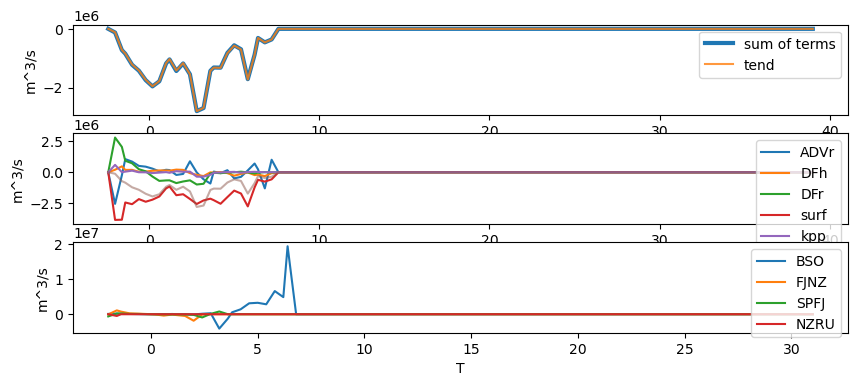

In [224]:
fig = plt.figure()
terms = np.array(["ADVr","DFh","DFr","surf","kpp"])

ax = plt.subplot(311)

ax.plot(boundsT.flatten()[1:-1],np.nansum(dF_Tnew[:-1],axis=0),linewidth=3,label="sum of terms")                 # the terms contributing to temperature
ax.plot(boundsT.flatten()[1:-1],dF_Tnew[-1],label='tend',alpha=0.8)  # total tendency as calculated from snaps
ax.legend(loc="best")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")

ax = plt.subplot(312)
for i in range(1,6):
    ax.plot(boundsT.flatten()[1:-1],dF_Tnew[i],label=terms[i-1])                 # the terms contributing to temperature
ax.plot(boundsT.flatten()[1:-1],dF_Tnew[-1],label='tend',alpha=0.5)  # total tendency as calculated from snaps
ax.legend(loc="best")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")

ax = plt.subplot(313)

ax.plot(boundsT.flatten()[1:-1],G_BSOT/binwidthT1,label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZT/binwidthT1,label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJT/binwidthT1,label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRUT/binwidthT1,label="NZRU")
ax.legend(loc="best")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")

Text(0.5, 0, 'T')

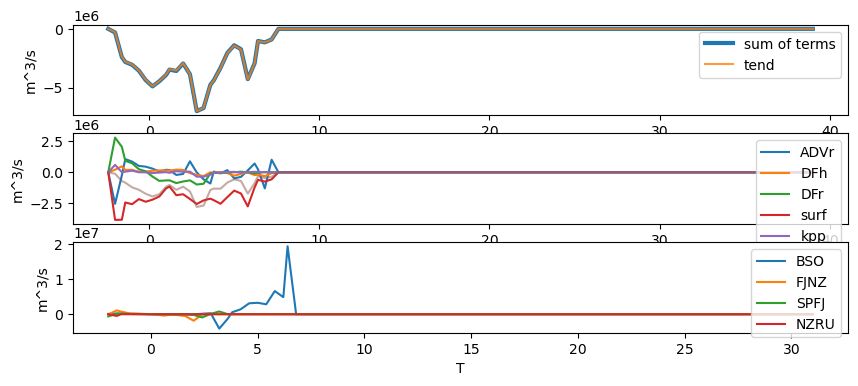

In [225]:
fig = plt.figure()
terms = np.array(["ADVr","DFh","DFr","surf","kpp"])

ax = plt.subplot(311)

ax.plot(boundsT.flatten()[1:-1],np.nansum(G_T_offline_new[:-1],axis=0),linewidth=3,label="sum of terms")                 # the terms contributing to temperature
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[-1],label='tend',alpha=0.8)  # total tendency as calculated from snaps
ax.legend(loc="best")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")

ax = plt.subplot(312)
for i in range(1,6):
    ax.plot(boundsT.flatten()[1:-1],dF_Tnew[i],label=terms[i-1])                 # the terms contributing to temperature
ax.plot(boundsT.flatten()[1:-1],dF_Tnew[-1],label='tend',alpha=0.5)  # total tendency as calculated from snaps
ax.legend(loc="best")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")

ax = plt.subplot(313)

ax.plot(boundsT.flatten()[1:-1],G_BSOT/binwidthT1,label="BSO")
ax.plot(boundsT.flatten()[1:-1],G_FJNZT/binwidthT1,label="FJNZ")
ax.plot(boundsT.flatten()[1:-1],G_SPFJT/binwidthT1,label="SPFJ")
ax.plot(boundsT.flatten()[1:-1],G_NZRUT/binwidthT1,label="NZRU")
ax.legend(loc="best")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")

In [226]:
x = (np.nansum(G_T_offline_new[-1])) / (np.nansum(G_T_offline_new[:-1]))
print(x)
tend = G_T_offline_new[-1]/x
otherterms = np.nansum(G_T_offline_new[:-1],axis=0)
print(np.nansum(tend-otherterms))

0.9980629085479357
1.9674189388751984e-08


In [227]:
# # debugging

# RAC3d = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))
# vol_sample = np.nansum(RAC3d * DRF3d * hfC * mymsk3d)
# 277611284752191.38/2673211.6942547904

In [228]:
# make a bar chart of the overall contribution by each gate -- show that this is budgeted
# the point of this will be to show that the contribution of the gates is the same and equals the contribution of the ADVh

ADVhsum = (np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1)) # m^3/s
BSOT_sum = np.nansum(G_BSOT) / np.nansum(binwidthT1)
FJNZT_sum = np.nansum(G_FJNZT) / np.nansum(binwidthT1)
SPFJT_sum = np.nansum(G_SPFJT) / np.nansum(binwidthT1)
NZRUT_sum = np.nansum(G_NZRUT) / np.nansum(binwidthT1)

print(ADVhsum)
print(BSOT_sum+FJNZT_sum+SPFJT_sum+NZRUT_sum)
gates = (BSOT_sum+FJNZT_sum+SPFJT_sum+NZRUT_sum)

print()

for i in range(1,6):
    # print the sum of the other terms
    print(terms[i-1],np.nansum(dF_Tnew[i]) / np.nansum(binwidthT1),"m^3/s")

496224.3159182641
278490.0749704533

ADVr -1.1126912480471669e-11 m^3/s
DFh 5857.433285612253 m^3/s
DFr 1.1126912480471669e-11 m^3/s
surf -1257049.394029027 m^3/s
kpp 0.0 m^3/s


In [176]:
# haven't figured this one out yet


In [177]:
# these can all be numbers in a timeseries
x = (np.nansum(dF_Tnew[-1])/ np.nansum(binwidthT1)) / (np.nansum(dF_Tnew[:-1]) / np.nansum(binwidthT1))
print()
ctend = np.nansum(dF_Tnew[:-1]) / np.nansum(binwidthT1)
print("calc tend",ctend)
tend = np.nansum(dF_Tnew[-1])/x / np.nansum(binwidthT1)
print("tend",tend)

print()
otherterms = np.nansum(dF_Tnew[1:-1]) / np.nansum(binwidthT1)
print(otherterms)
print()
print("resid",tend - otherterms - gates)


calc tend -754967.6448251507
tend -754967.6448251507

-1251191.960743415

resid 2.3283064365386963e-10


## manually define create_layersTHETA

In [178]:
# manually check create_layersSALT
def create_layersSALT(tsstr,mygrid,myparms,dirdiags,dirState,layers_path,mymsk,nz,ny,nx,nfx,nfy,dt):
    # do the same as previous but return the values in salt
        # we want to create dF_Tnew, basically, which contains the information from the layers output mimicked by ASTER1
    # let's just check with ADVh first
    mymsk3d = np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
    t2 = int(tsstr[1])
    hf = mygrid['hFacC']
    RAC = mygrid['RAC']
    
    # load THETA
    file_name = "state_3d_set1"
    meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
    SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])
    THETA = THETA.reshape(nz,ny,nx)
    SALT = SALT.reshape(nz,ny,nx)

    ## load the TS bins
    boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
    nT = boundsT.size - 1
    boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
    nS = boundsS.size - 1
    
    binwidthT = boundsT[1:] - boundsT[:-1]
    binwidthS = boundsS[1:] - boundsS[:-1]
    
    binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])
    binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])
    
    binmidT = (boundsT[1:] + boundsT[:-1]) /2
    binmidS = (boundsS[1:] + boundsS[:-1]) /2
    
    nT = nT
    nS = nS
    nTm1 = nT-1
    nSm1 = nS-1

    # load the advective terms for salt
    ############################################################
    # get the internal transformations
    file_name = "budg3d_hflux_set2"
    meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["ADVx_SLT","ADVy_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVx_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    
    ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_SLT.reshape(nz, ny, nx), nfx, nfy))
    ADV_hconv = ADV_hconv   # PSU·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
    ADVhS = ADV_hconv
    
    # now 3d zfluxes
    file_name = "budg3d_zflux_set2"
    meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
    varnames = np.array(["ADVr_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVr_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
    
    hf = mygrid['hFacC']
    
    trWtopADV = -(ADVr_SLT)
    
    ADVrS = np.zeros((nz,ny,nx),dtype=float)
    ADVrS[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])

    ############################################################
    # load the other terms, copy from below

    file_name = "budg3d_hflux_set2"
    meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["DFxE_SLT","DFyE_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    DFxE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    DFyE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    
    
    # now 3d zfluxes
    file_name = "budg3d_zflux_set2"
    meta_budg3d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
    varnames = np.array(["DFrE_SLT","DFrI_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    DFrE_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    DFrI_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
    DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)
    
    DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_SLT.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_SLT.reshape(nz, ny, nx), nfx, nfy))
    DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
    DFhS = DF_hconv
    
    trWtopDF = -(DFrE_SLT+DFrI_SLT)
    
    DFrS = np.zeros((nz,ny,nx),dtype=float)
    DFrS[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])
    
    # load the surface terms
    # read fluxes
    file_name = 'budg2d_zflux_set1'
    meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
    varnames = np.array(["oceSPflx","SFLUX"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    oceSPflx,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    SFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    oceSPflx = oceSPflx.reshape(ny,nx)
    SFLUX = SFLUX.reshape(ny,nx)
    
    # read relax and salt mass
    file_name = "budg2d_zflux_set2"
    meta_budg2d_zflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
    varnames = np.array(["oceSflux","WSLTMASS"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        if len(irec[0]) > 0:
            recs = np.append(recs, irec[0][0])
    oceSflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    WSLTMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    oceSflux = oceSflux.reshape(ny,nx)
    WSLTMASS = WSLTMASS.reshape(ny,nx)
    
    # read kpp tend and from 3d zflux
    file_name = "budg3d_kpptend_set1"
    meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
    varnames = np.array(["oceSPtnd","KPPg_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        if len(irec[0]) > 0:
            recs = np.append(recs, irec[0][0])
    oceSPtnd,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    KPPg_SLT,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
    oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
    KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)
    
    RAC3 = np.tile(RAC[np.newaxis,:,:],(nz,1,1))
    sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
    sptop = sptop * RAC3        # g/s
    
    zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
    
    def surface_contrib_JT(zconv_top_salt, sptop, rho, fill_last=0.0):
        """
        zconv_top_heat: (ny, nx)
        swtop:          (nz, ny, nx)
        rcp:            scalar
        fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
        returns:
          JsurfT:       (nz, ny, nx)  # Sv / PSU
        """
        nz, ny, nx = sptop.shape
    
        eS = zconv_top_salt.reshape(1, ny, nx)  # (1,ny,nx) for broadcast
    
        J = np.empty_like(sptop, dtype=float)
    
        # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
        J[0] = (eS[0] - sptop[1]) / rho if np.ndim(binwidthS)==0 else \
               (eS[0] - sptop[1]) / rho
    
        # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
        J[1:nz] = -(sptop[1:nz] - sptop[0:nz-1]) / rho
    
        # bottom slice (k = nz-1): no k+1; choose your boundary convention
        J[-1] = fill_last
        return J
    
    Ft_surftest = surface_contrib_JT(zconv_top_salt,sptop,myparms['rhoconst'])    # this is in PSU.m^3/s
    
    # do the vertical convergence for KPP
    trWtopKPP = -(KPPg_SLT)         # PSU.m^3/s
    
    tmpkpp = np.full((nz,ny,nx),np.nan)
    tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
    
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    for i in range(len(tsstr)):
        thisSALTDR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
        thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
        SALTDR[i] = thisSALTDR
    
    SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s
    #print(np.nansum(SALTDR),dt)
    
    tmptend = (SALTDR - 0) * mk3D_mod(RAC,SALTDR)    # PSU.m/s * m^2 = PSU.m^3/s

    ############################################################
    # write these to a dF_Snew, so we can output and verify
    # redefine all the terms as a list from how we did before

    # define the ADVh total for this mymsk2
    G_S_offline_new = np.zeros((7, nS-1))
    dF_Snew = np.zeros((7, nS-1))
    Lijnew = np.zeros((7, nS-1), dtype=int)
    
    # also mask these by mymsk3
    # flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
    S_flat    = np.ravel(SALT* mymsk3d, order='F')
    ADVh_flat = np.ravel(ADVhS* mymsk3d,  order='F')
    ADVr_flat = np.ravel(ADVrS* mymsk3d,  order='F')
    DFh_flat = np.ravel(DFhS* mymsk3d,  order='F')
    DFr_flat = np.ravel(DFrS* mymsk3d,  order='F')
    surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
    kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
    tend_flat = np.ravel(tmptend* mymsk3d,  order='F')
    
    for i in range(nT-1):
        # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
        ij = np.where((S_flat >= binmidS[i]) & (S_flat < binmidS[i + 1]))[0]
        Lijnew[0, i] = len(ij)
    
        if len(ij) > 0:
            # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
            dF_Snew[0, i] = np.nansum(ADVh_flat[ij])
            dF_Snew[1, i] = np.nansum(ADVr_flat[ij])
            dF_Snew[2, i] = np.nansum(DFh_flat[ij])
            dF_Snew[3, i] = np.nansum(DFr_flat[ij])
            dF_Snew[4, i] = np.nansum(surf_flat[ij])
            dF_Snew[5, i] = np.nansum(kpp_flat[ij])
            dF_Snew[6, i] = np.nansum(tend_flat[ij])
    
    # MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
    G_S_offline_new = dF_Snew / binwidthS1[None, :]
    
    return G_S_offline_new,dF_Snew  # these will be in units of m^3/s and PSU.m^3/s

In [179]:
G_S_offline_new,dF_Snew = create_layersSALT(tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy,dt)
print(np.nansum(dF_Snew[0]) / np.nansum(binwidthS1))   # appears fixed now
print(np.nansum((G_BSOS + G_FJNZS + G_SPFJS + G_NZRUS)) / np.nansum(binwidthS1))  # in m^3/s


27874.38349753812
27874.38349754129


In [180]:
# the one above is at least working, so maybe we can move things up
x = (np.nansum(G_S_offline_new[-1])) / (np.nansum(G_S_offline_new[:-1]))
print(x)
tend = G_S_offline_new[-1]/x
otherterms = np.nansum(G_S_offline_new[:-1],axis=0)
print(np.nansum(tend-otherterms))

1.0001481956161578
1.5381374396383762e-08


In [181]:
# make a bar chart of the overall contribution by each gate -- show that this is budgeted
# the point of this will be to show that the contribution of the gates is the same and equals the contribution of the ADVh

ADVhsum = (np.nansum(dF_Snew[0]) / np.nansum(binwidthS1)) # m^3/s
BSOS_sum = np.nansum(G_BSOS) / np.nansum(binwidthS1)
FJNZS_sum = np.nansum(G_FJNZS) / np.nansum(binwidthS1)
SPFJS_sum = np.nansum(G_SPFJS) / np.nansum(binwidthS1)
NZRUS_sum = np.nansum(G_NZRUS) / np.nansum(binwidthS1)

print(ADVhsum)
print(BSOS_sum+FJNZS_sum+SPFJS_sum+NZRUS_sum)
gates = (BSOS_sum+FJNZS_sum+SPFJS_sum+NZRUS_sum)

print()

for i in range(1,6):
    # print the sum of the other terms
    print(terms[i-1],np.nansum(dF_Snew[i]) / np.nansum(binwidthS1),"m^3/s")

27874.38349753812
27874.383497540446

ADVr 1.1818814398673584e-10 m^3/s
DFh -701.2880276872942 m^3/s
DFr 0.0 m^3/s
surf -3148.8204184909478 m^3/s
kpp -1.1541810936204673e-14 m^3/s


In [182]:
# these can all be numbers in a timeseries
x = (np.nansum(dF_Snew[-1])/ np.nansum(binwidthS1)) / (np.nansum(dF_Snew[:-1]) / np.nansum(binwidthS1))
print()
ctend = np.nansum(dF_Snew[:-1]) / np.nansum(binwidthS1)
print("calc tend",ctend)
tend = np.nansum(dF_Snew[-1])/x / np.nansum(binwidthS1)
print("tend",tend)

print()
otherterms = np.nansum(dF_Snew[1:-1]) / np.nansum(binwidthS1)
print("other terms",otherterms)
print()
print("resid",tend - otherterms - gates)


calc tend 24024.27505136002
tend 24024.27505136002

other terms -3850.108446178124

resid -2.3028405848890543e-09


## Now, this is effectively closed for one time step, we can create the overall contributions in m^3/s for a given year

An will not like this, but this will help to show closure and see the seasons.

From this we can also create a climatology which will be the comparison we make 

In [183]:
# Let's try to run this for the year 2007

In [235]:
# let's move the gate calculation to a function to show a timeseries
# define tstep

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times['2007'] = np.arange(2,5,1)
# times['2008'] = np.array([1])

# the filenames we want for 2014
tsstrfull,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)
tsstrfull

array(['0000267408', '0000271440', '0000275904'], dtype='<U32')

In [236]:
# once we make this we will not have time to analyze it so it may be good to take a step back and purely compare
# one time step for 2007 and 2016

In [241]:
# for each time step, load ADVx and ADVy and THETA and SALT

def gates_check(tsstr):

    t2 = int(tsstr[1])

    ############################################################
    # load the data for that time
    # read theta and salt averages from the t2 timestep (average)
    file_name = "state_3d_set1"
    meta_state_3d_set1 = parsemeta(forward_path + "diags/STATE/" + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_state_3d_set1["fldList"])
    varnames = np.array(["THETA","SALT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    THETA,its,meta = rdmds(os.path.join(forward_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[0])
    SALT,its,meta = rdmds(os.path.join(forward_path + "diags/STATE/", file_name),t2,returnmeta=True,rec=recs[1])
    THETA = THETA.reshape(nz,ny,nx)
    SALT = SALT.reshape(nz,ny,nx)

    # LOAD ADV FOR BOTH T AND S
    file_name = "budg3d_hflux_set2"
    meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
    varnames = np.array(["ADVx_TH","ADVy_TH","ADVx_SLT","ADVy_SLT"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
    ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])

    ############################################################

    # generate the M terms from the gate
    ADV_westT, ADV_FJNZT, ADV_SPFJT, ADV_NZRUT = get_gates3d(ADVx_TH,ADVy_TH,THETA,nz,ny,nx)
    ADV_westS, ADV_FJNZS, ADV_SPFJS, ADV_NZRUS = get_gates3d(ADVx_SLT,ADVy_SLT,SALT,nz,ny,nx)
    G_BSOT,G_FJNZT,G_SPFJT,G_NZRUT = gateway3D(ADV_westT,ADV_FJNZT,ADV_SPFJT,ADV_NZRUT,THETA,binmidT,nTm1)  # in tracer.m^3/s
    G_BSOS,G_FJNZS,G_SPFJS,G_NZRUS = gateway3D(ADV_westS,ADV_FJNZS,ADV_SPFJS,ADV_NZRUS,SALT,binmidS,nSm1)  # in tracer.m^3/s
    print("gates calculated")

    ############################################################

    # get the G terms from the fields
    G_T_offline_new,dF_Tnew = create_layersTHETA(tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy,dt)
    print("G_T calculated")
    G_S_offline_new,dF_Snew = create_layersSALT(tsstr,mygrid,myparms,dirdiags,dirstate,layers_path,mymsk,nz,ny,nx,nfx,nfy,dt)
    print("G_S calculated")

    # print a check for the gates
    print("salt check")
    ADVhsum = (np.nansum(dF_Snew[0]) / np.nansum(binwidthS1)) # m^3/s
    BSOS_sum = np.nansum(G_BSOS) / np.nansum(binwidthS1)
    FJNZS_sum = np.nansum(G_FJNZS) / np.nansum(binwidthS1)
    SPFJS_sum = np.nansum(G_SPFJS) / np.nansum(binwidthS1)
    NZRUS_sum = np.nansum(G_NZRUS) / np.nansum(binwidthS1)
    print("ADVhT:",ADVhsum)
    print("gates T:",BSOS_sum+FJNZS_sum+SPFJS_sum+NZRUS_sum)
    gatesS = (BSOS_sum+FJNZS_sum+SPFJS_sum+NZRUS_sum)


    # these can all be numbers in a timeseries
    x = (np.nansum(dF_Snew[-1])/ np.nansum(binwidthS1)) / (np.nansum(dF_Snew[:-1]) / np.nansum(binwidthS1))
    print()
    ctend = np.nansum(dF_Snew[:-1]) / np.nansum(binwidthS1)
    print("calc tend",ctend)
    tend = np.nansum(dF_Snew[-1])/x / np.nansum(binwidthS1)
    print("tend",tend)
    otherterms = np.nansum(dF_Snew[1:-1]) / np.nansum(binwidthS1)
    print("other terms",otherterms)
    print()
    print("resid",tend - otherterms - gatesS)
    
    print("temp check")
    ADVhsum = (np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1)) # m^3/s
    BSOT_sum = np.nansum(G_BSOT) / np.nansum(binwidthT1)
    FJNZT_sum = np.nansum(G_FJNZT) / np.nansum(binwidthT1)
    SPFJT_sum = np.nansum(G_SPFJT) / np.nansum(binwidthT1)
    NZRUT_sum = np.nansum(G_NZRUT) / np.nansum(binwidthT1)
    print("ADVhS:",ADVhsum)
    print("gates S:",BSOT_sum+FJNZT_sum+SPFJT_sum+NZRUT_sum)
    gatesT = (BSOT_sum+FJNZT_sum+SPFJT_sum+NZRUT_sum)


    # print a check for the overall closure
    x = (np.nansum(dF_Tnew[-1])/ np.nansum(binwidthT1)) / (np.nansum(dF_Tnew[:-1]) / np.nansum(binwidthT1))
    print()
    ctend = np.nansum(dF_Tnew[:-1]) / np.nansum(binwidthT1)
    print("calc tend",ctend)
    tend = np.nansum(dF_Tnew[-1])/x / np.nansum(binwidthT1)
    print("tend",tend)
    otherterms = np.nansum(dF_Tnew[1:-1]) / np.nansum(binwidthT1)
    print(otherterms)
    print("resid",tend - otherterms - gatesT)
    print()
    

In [ ]:
for i in range(len(tsstrfull)-1):
    tsstr = tsstrfull[i:i+2]
    print(tsstr)
    gates_check(tsstr)

['0000267408' '0000271440']
gates calculated
G_T calculated
G_S calculated
salt check
ADVhT: -28987.271738314394
gates T: -28987.271738314244

calc tend -32103.202515821115
tend -32103.202515821115
other terms -3115.9307775066936

resid -1.7462298274040222e-10
temp check
ADVhS: 278490.07497045334
gates S: 278490.0749704533

calc tend -888024.5344813787
tend -888024.5344813787
-1166514.6094518318
resid 307477.3467087673

['0000271440' '0000275904']
gates calculated
G_T calculated
